# Sentiment analysis of twitter real-time data

In Natural Language Processing(NLP), sentiment analysis of data such as user reviews or social media opinion about a specific entity reveals the current general public opinion about it. The entity could be a firm or person or a product. This investigation helps the investors to decide on financing and owners to improve the product quality or design.

Tweepy is the API we use to communicate with real-time Twitter server. The credentials including key and token for API is created with "https://developer.twitter.com/en". It is then stored as CSV file and imported as dataframe. We use TextBlob package to analyse the polarity and sensitivity of the messages in tweets.

In [2]:
#Importing required packages
import tweepy as ty
import pandas as pd
import matplotlib.pyplot as plt
import re
from textblob import TextBlob
from wordcloud import WordCloud

I have defined data extraction, cleaning and analysis in seperate methods. All the methods are grouped under a single class. The initialization class takes following parameters to be used throught-out the process and assigns it to respective variables:

1) file_path - local csv file path to the twitter authentication data <br>
2) search_words - specific twitter user name or hashtag to be searched for tweets <br>
3) date_since - starting date to extract tweets from <br>
4) tweet_count - number of tweets to be extracted <br>
5) print_tweet - flag to print tweet or not <br>
6) print_choice - to print choice of tweet (negative/neutral/positive)

In [4]:
class sentiment_analysis():
    
        def __init__(self, file_path, search_words, date_since, tweet_count, print_tweet, print_choice):
            self.file_path = file_path
            self.search_words = search_words
            self.date_since = date_since
            self.tweet_count = tweet_count
            self.print_tweet = print_tweet
            self.print_choice = print_choice

In the method authentication we pass API token, API secret token, API key and API secret key and establish a connection with real-time twitter data.

In [18]:
def authentication(self):
    auth_df = pd.read_csv(self.file_path)

    authenticate = ty.OAuthHandler(auth_df[auth_df["Name"]=='API key']["Key"].iloc[0],auth_df[auth_df["Name"]=='Secret key']["Key"].iloc[0] )

    authenticate.set_access_token(auth_df[auth_df["Name"]=='Access token']["Key"].iloc[0],auth_df[auth_df["Name"]=='Access token secret']["Key"].iloc[0])

    api = ty.API(authenticate,wait_on_rate_limit=True)
    return(api)

sentiment_analysis.authentication = authentication

The data_parsing method takes search_words, date_since and tweet_count as input and through established connection extracts data.

In [19]:
def data_parsing(self, api):
        tweets = ty.Cursor(api.search_tweets, q=self.search_words, lang="en", since=self.date_since).items(self.tweet_count)

        a = [[tweet.user.screen_name,tweet.user.location,tweet.text] for tweet in tweets]

        self.tweets_df = pd.DataFrame(a,columns=['USER','LOCATION','TWEET'])
        
sentiment_analysis.data_parsing = data_parsing            

The extracted tweets will have all types of data including datetime, name of tweet owner, message. In data_cleaning  method we seperate name of tweet owner in 'USER', region in 'LOCATION' and tweet in 'TWEET'. In next iteration is to extract tagged usernames into 'TAGS', mentioned hyper-links into 'URL' and emoticon-free message into 'MESSAGE' columns.

In [20]:
def data_cleaning(self):
    self.tweets_df["TAGS"] = (self.tweets_df["TWEET"].str.extractall(pat='(@[A-Za-z0-9_]+)').unstack().apply(lambda x:', '.join(x.dropna()), axis=1))

    self.tweets_df["URL"] = (self.tweets_df["TWEET"].str.extractall(pat='(\w+:\/\/\S+)').unstack().apply(lambda x:', '.join(x.dropna()), axis=1))

    self.tweets_df["MESSAGE"] = self.tweets_df["TWEET"].apply(lambda x: re.sub('(@[A-Za-z0-9_]+)|(\w+:\/\/\S+)','',x))

    self.tweets_df["MESSAGE"] = self.tweets_df[["MESSAGE"]].astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

    self.tweets_df["MESSAGE"] = self.tweets_df["MESSAGE"].apply(lambda x: re.sub('RT :','',x))
    
sentiment_analysis.data_cleaning = data_cleaning        

The subjectivity and polarity of the tweet is calculated using inbuilt functions in textblob. Using the polarity score, tweet is categorized into negative, neutral or positive reaction.

In [21]:
def data_analysis(self):
    self.tweets_df["SUBJECTIVITY"] = self.tweets_df["MESSAGE"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

    self.tweets_df["POLARITY"] = self.tweets_df["MESSAGE"].apply(lambda x: TextBlob(x).sentiment.polarity)

    self.tweets_df["RESULT"] = self.tweets_df["POLARITY"].apply(self.getAnalysis)

def getAnalysis(self,score):
    if score < 0:
        return "NEGATIVE"
    elif score == 0:
        return "NEUTRAL"
    elif score > 0:
        return "POSITIVE"
    
sentiment_analysis.data_analysis = data_analysis
sentiment_analysis.getAnalysis = getAnalysis

A word cloud will display frequently used words in all tweets with different range of size dependeing upon the frequency

In [22]:
def data_visualization(self):
    allwords = ''.join([twts for twts in self.tweets_df["MESSAGE"]])
    wordcloud = WordCloud(width = 500, height=200, random_state=21, max_font_size=119).generate(allwords)
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis('off')
    plt.show
    
sentiment_analysis.data_visualization = data_visualization

In result_analysis we count the number of tweets getting classified into three different categories, their percentage and also plot them using a pie-chart and bar-plot. Here is where a specific category of tweet is being displayed on user request.

In [28]:
def result_analysis(self):
            negative_count = self.tweets_df[self.tweets_df["RESULT"]=="NEGATIVE"]["MESSAGE"].count()
            positive_count = self.tweets_df[self.tweets_df["RESULT"]=="POSITIVE"]["MESSAGE"].count()
            neutral_count  = self.tweets_df[self.tweets_df["RESULT"]=="NEUTRAL"]["MESSAGE"].count()
            tweets_count   = self.tweets_df["MESSAGE"].count()
            negative_percentage = (negative_count/tweets_count)*100
            positive_percentage = (positive_count/tweets_count)*100
            neutral_percentage  = (neutral_count/tweets_count)*100
            if self.print_tweet != "N":
                if self.print_choice == "NEG":
                    for tweet in self.tweets_df[self.tweets_df["RESULT"]=="NEGATIVE"]["MESSAGE"]:
                        print((tweet))
                elif self.print_choice == "NEU":
                    for tweet in self.tweets_df[self.tweets_df["RESULT"]=="POSITIVE"]["MESSAGE"]:
                        print((tweet))
                elif self.print_choice == "POS":
                    for tweet in self.tweets_df[self.tweets_df["RESULT"]=="NEUTRAL"]["MESSAGE"]:
                        print((tweet))

            plt.figure(figsize=(10,5))
            plt.bar(['NEGATIVE','NEUTRAL','POSITIVE'],[negative_percentage, neutral_percentage, positive_percentage])
            plt.xlabel("SENTIMENT")
            plt.ylabel("COUNT")
            plt.title("DISTRIBUTION OF SENTIMENTS")
            plt.figure(figsize=(40,5))
            plt.pie([negative_percentage, neutral_percentage, positive_percentage], labels= [negative_percentage, neutral_percentage, positive_percentage], explode=(0.2,0.2,0.2))
            plt.legend(['NEGATIVE', 'NEUTRAL', 'POSITIVE'], loc=3)

sentiment_analysis.result_analysis = result_analysis

This method calls other methods one after the other in required order and takes care of the processes

In [29]:
def tweet_analysis(self):
    api = self.authentication()
    self.data_parsing(api)
    self.data_cleaning()
    self.data_analysis()
    self.data_visualization()
    self.result_analysis()
    
sentiment_analysis.tweet_analysis = tweet_analysis

The main method creates object for class sentiment_analysis and passes needed argument to initialize the class

Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since


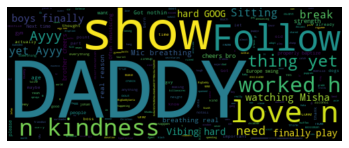

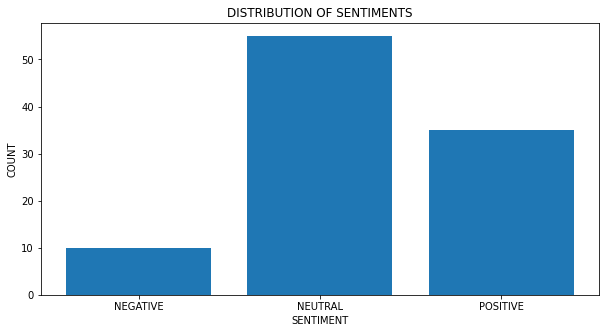

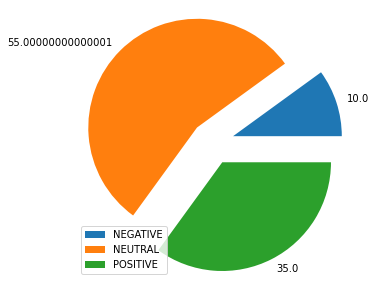

In [30]:
if __name__ == "__main__":
    file_path = r'C:\Users\Admin\OneDrive\Desktop\auth_twitter.csv'
    search_words = "@OG_BDN0tail"
    date_since = "2021-11-01"
    tweet_count = 200
    print_tweet = "N"
    print_choice = "NEG"
    senti = sentiment_analysis(file_path, search_words, date_since, tweet_count, print_tweet, print_choice)
    senti.tweet_analysis()